# Introduction: Random Forest Sea Level Occurrences

This notebook can be used to reproduce the results shown in [Bellinghausen et al. 2024](https://egusphere.copernicus.org/preprints/2024/egusphere-2024-2222/).  
With this we provide an examplatory dataset that does not contain the full range as shown in the paper due to limited storage capacities.  
You can use this notebook to adjust it towards your needs.

## What you can adjust
You can adjust the 2D-spatial map of the input predictor as long as the format is similar to the one we show in the examplatory data.  
The visualisation tool should still be able to provide the predictor maps and area of importances. 

## What you can not adjust

The model is based on the GESLA dataset and many functions are acustomed to that dataset.  
So the easiest is it to check whether a station of interest is already existing within the GESLA dataset and to use that.  
Of course you can also build your own predictand but most likely errors will occur when using the model as stated below. 

## What to expect

In the following steps this notebook will briefly guide you through the setup of the model. 

First we will [load necessary modules](#loading-modules).  
You can find the necessary packages in the `requirements.txt` file. 

As for now we do not provide the preprocessing but give [examplatory data of how your preprocessed data should look like](#loading-datasets-and-further-preprocessing)

We then [setup an experiment](#setting-up-an-experiment--model-fit) and conclude with a [complete model run](#make-an-experiment). 

# Loading Modules

In [38]:
# General
import os
import sys
from importlib import reload
import pickle
import glob

# Datasets
from gesla import GeslaDataset

# Data Handling & Statistics
import xarray as xr
import numpy as np 
import pandas as pd
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Plots
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Own Modules
from data import data_loader
from data import saver
from data import visualisation 
from data import gesla_preprocessing
from data import preprocessing
from data import xarray_tools as xrt
from models import modelfit
from models import evaluation
from models import loader

# Preprocessing your data

For now we do not provide the preprocessing but give examplatory data below.  
Make sure to have your data in a similar format before starting the main model run.

You can find the steps of preprocessing we have used in the methods section of [Bellinghausen et al. 2024](https://egusphere.copernicus.org/preprints/2024/egusphere-2024-2222/)

## Examplatory Preprocessing of GESLA data

We do not provide the GESLA dataset with this notebook due to data-storage restrictions. 

The [Preprocessing](#preprocessing-gesla-data) should work though if you load the original GESLA data into a variable called `gesla`

### Loading Original GESLA Data

In [ ]:
#---
# Load Data of Specific Stations
#---
meta_file = "path/to/GESLA3_ALL.csv" # Replace this
data_path = "path/to/GESLA3.0_ALL.zip" # Replace this
station_names = [
    "kalixstoron-kal-swe-cmems", # Replace with station of your choice
]
is_analysis = True # Whether to choose data qualified for analysis in GESLA dataset

g3 = GeslaDataset(meta_file=meta_file, data_path=data_path)
gesla = g3.files_to_xarray(station_names)

# Select only analysis data
#--- 
if is_analysis:
    gesla = gesla.where(
        gesla.use_flag == 1., # Analysis flag
        drop = True,
        )

### Preprocessing GESLA Data

The following steps are done in the preprocessing:

1. Compute Daily Averages
2. Select target_months
3. Polyfit Detrending
    Results are stored in: "detrended" and "trend"
4. (Optional, **not done for MA Review**): Tidal Signal Removal (using a bandpass filter)
    Results are stored in: "bandpass_filtered" and "signal"
5. Classification based on a percentile (One-Hot-Encoding)
    Results are stored in: "classified_bandpass_filtered"
6. Calculating Daily Maxima of the Classification
    A new Dataset is created based on "classified_bandpass_filtered"

In [ ]:
#---
# Initialization
#---
# Those DataArrays are created later within the preprocessing.
dv1 = "sea_level"
dv2 = "detrended"
f = "gesla_daily.nc"
dim1 = "station"
dim2 = "date_time"
target_months = [9, 10, 11, 12, 1, 2,]
percentile = 0.95
deg = 1 # Degree of the polynomial fit.
fs = 1
p_high = 14
p_low = 10
order = 4

#---
# Preprocessing
#---
# Ensures that the information on the station names is not lost.
gesla = gesla_preprocessing.stations_as_coordinates(gesla, is_analysis)

# Calculate Averages and Save
gesla = gesla.resample(date_time='1D').mean()

# Select Target Months
gesla = gesla.sel({dim2 : gesla[f'{dim2}.month'].isin(target_months)})

# Detrending
gesla = xrt.poly_detrend(gesla, dim=dim2, dv=dv1, group_dim=dim1, deg=deg)

# Optional: Apply a bandpass filter

# gesla = xrt.bandpass_filter(
#     ds=gesla,
#     group_dim=dim1,
#     dv_name=dv2,
#     p_high=p_high,
#     p_low=p_low,
#     fs=fs,
#     order=order,
#     nan_handle="zeros",
# )

#---
# Classify the Data
#---
gesla = xrt.classify_percentiles(
    dataset = gesla,
    var_name = dv2, # Change this if you used the bandpass filter.
    percentile = percentile,
    dim = dim2,
    dim_p = dim1,
    skipna = True,
    dropna = False,
)

# The Model

## Loading datasets and further preprocessing

In this section we load the dataset of the predictor and predictand.   
All examplatory datasets are stored in `examples/`.   

It is important that your data has the same format and structure as the examplatory data given here.   
Otherwise the main model will probably not run as expected (and you will have fun debugging 😎 🎉) 

### Load the predictand dataset

In [2]:
# Load predictand
data_folder = "examples"
train_path = f"{data_folder}/2005-2013-train_index-daily.nc"
test_path = f"{data_folder}/2014-2016-test-index-daily.nc"
valid_path = f"{data_folder}/2017-2018-validation-index-daily.nc"

predictand_train = xr.open_dataset(train_path)
predictand_test = xr.open_dataset(test_path)
predictand_valid = xr.open_dataset(valid_path)

The datasets look like this. For each station there is a timeseries of classifications.

<xarray.Dataset> Size: 579kB
Dimensions:               (station: 7, date_time: 3287)
Coordinates:
  * station               (station) <U25 700B 'oskarshamn-osk-swe-cmems' ... ...
  * date_time             (date_time) datetime64[ns] 26kB 2005-01-01 ... 2013...
    quantile              float64 8B ...
    train_set_percentile  (station) float64 56B ...
Data variables:
    exceedance            (station, date_time) float64 184kB ...
    latitude              (station, date_time) float64 184kB ...
    longitude             (station, date_time) float64 184kB ...

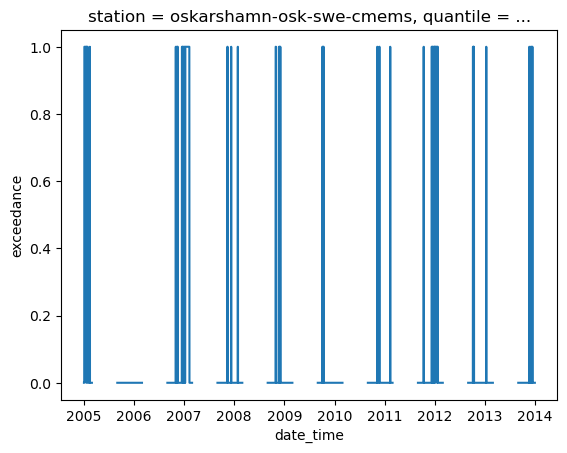

In [3]:
predictand_train["exceedance"].isel(station=0).plot()
predictand_train

### Load predictor dataset

In [4]:
# Load Predictor
data_folder = "examples"
train_path = f"{data_folder}/predictor-train.nc" # f"{data_folder}/2005-2013-train_predictor-daily.nc"
test_path = f"{data_folder}/predictor-test.nc" # f"{data_folder}/2014-2016-test_predictor-daily.nc"
valid_path = f"{data_folder}/predictor-valid.nc" # f"{data_folder}/2017-2018-validation_predictor-daily.nc"
pf_train_path = f"{data_folder}/2005-2013-train_predictor-pf-daily.nc"
pf_test_path =  f"{data_folder}/2014-2016-test_predictor-pf-daily.nc"
pf_valid_path = f"{data_folder}/2017-2018-validation_predictor-pf-daily.nc"

era5_predictor_train = xr.open_dataset(train_path)
era5_predictor_test = xr.open_dataset(test_path)
era5_predictor_valid = xr.open_dataset(valid_path)
pf_predictor_train = xr.open_dataset(pf_train_path)["sea_level"].isel(station=0) # Only degerby station in there
pf_predictor_test = xr.open_dataset(pf_test_path)["sea_level"].isel(station=0)
pf_predictor_valid = xr.open_dataset(pf_valid_path)["sea_level"].isel(station=0)

The predictor data of ERA5 before adjusting its format to pass it to the random forest looks like this.

Here we selected zonal wind `u10` at one timestep for the plot.  
Note that the data variables in this dataset are the ones that you can draw from later on when [setting up the experiment](#setting-up-an-experiment--model-fit).

<xarray.Dataset> Size: 49MB
Dimensions:  (lon: 141, lat: 121, time: 181)
Coordinates:
  * lon      (lon) float64 1kB -5.0 -4.75 -4.5 -4.25 ... 29.25 29.5 29.75 30.0
  * lat      (lat) float64 968B 40.0 40.25 40.5 40.75 ... 69.25 69.5 69.75 70.0
  * time     (time) datetime64[ns] 1kB 2005-01-01 2005-01-02 ... 2005-12-31
Data variables:
    sp       (time, lat, lon) float32 12MB ...
    tp       (time, lat, lon) float32 12MB ...
    u10      (time, lat, lon) float32 12MB ...
    v10      (time, lat, lon) float32 12MB ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Sun Oct 13 10:07:39 2024: cdo -O -s -chname,var134,sp /scra...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

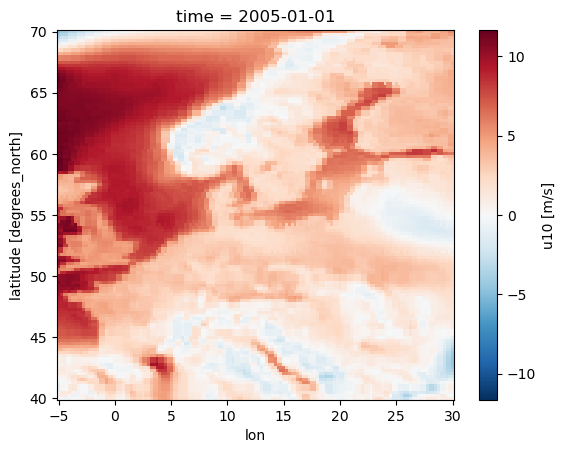

In [5]:
era5_predictor_train["u10"].isel(time=0).plot()
era5_predictor_train

The data of prefilling looks like this.  
Note, that not the full timeseries is passed to the model but specific timepoints of this sea level are added as a feature to the model.

<xarray.DataArray 'sea_level' (date_time: 3287)> Size: 26kB
[3287 values with dtype=float64]
Coordinates:
    station    <U21 84B 'degerby-deg-fin-cmems'
  * date_time  (date_time) datetime64[ns] 26kB 2005-01-01 ... 2013-12-31

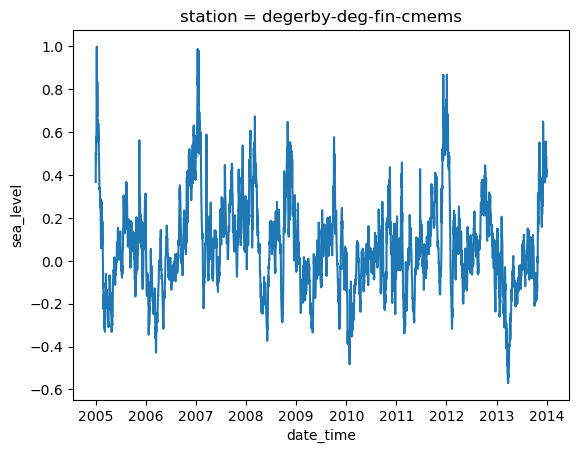

In [6]:
pf_predictor_train.plot()
pf_predictor_train

### Temporally intersect predictor and predictand

To ensure that the predictand and the predictor are on the same time-domain, we intersect them.   
We did that already during the preprocessing but here we introduce it once more to make sure they are really on the same time-domain.

In [7]:
# Intersect the timewindows of prefilling and ERA5
era5_predictor_train, pf_predictor_train = xrt.intersect1d(
    era5_predictor_train,
    pf_predictor_train,
    "time",
    "date_time",
)
era5_predictor_test, pf_predictor_test = xrt.intersect1d(
    era5_predictor_test,
    pf_predictor_test,
    "time",
    "date_time",
)
era5_predictor_valid, pf_predictor_valid = xrt.intersect1d(
    era5_predictor_valid,
    pf_predictor_valid,
    "time",
    "date_time",
)

# Intersect the timewindows of ERA5 predictor and predictand
era5_predictor_train, predictand_train = xrt.intersect1d(
    era5_predictor_train,
    predictand_train,
    "time",
    "date_time",
)
era5_predictor_test, predictand_test = xrt.intersect1d(
    era5_predictor_test,
    predictand_test,
    "time",
    "date_time",
)
era5_predictor_valid, predictand_valid = xrt.intersect1d(
    era5_predictor_valid,
    predictand_valid,
    "time",
    "date_time",
)

Now the predictand is also on the same timedomain as the predictor

<xarray.Dataset> Size: 33kB
Dimensions:               (station: 7, date_time: 181)
Coordinates:
  * station               (station) <U25 700B 'oskarshamn-osk-swe-cmems' ... ...
  * date_time             (date_time) datetime64[ns] 1kB 2005-01-01 ... 2005-...
    quantile              float64 8B ...
    train_set_percentile  (station) float64 56B ...
Data variables:
    exceedance            (station, date_time) float64 10kB ...
    latitude              (station, date_time) float64 10kB ...
    longitude             (station, date_time) float64 10kB ...

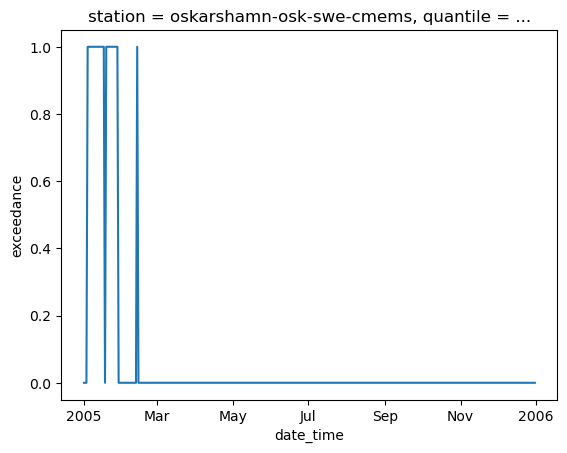

In [8]:
predictand_train["exceedance"].isel(station=0).plot()
predictand_train

### Save the positions of stations and longitude and latitude values of the ERA5 Predictor

To visualize the results in predictor maps we need to save the longitude and latitude information of the ERA5-predictors.

We also save the information of the stations location.

In [9]:
def get_station_positions(
    ds : xr.Dataset,
    
) -> dict:
    """Takes a dataset containing the GESLA stations and their longitude and latitude values
    stored as da'tavaraibles. Returns the positions of stations as a dictionary.

    Parameters:
        ds (xr.Dataset): The dataset
    Returns: 
        station_positions (dict,): Dicitionary with station name (key) and a list of [lon, lat] (values)
    """
    station_positions = {}
    for station in ds.station.values:
        station_lon = ds.sel(station=station)["longitude"].dropna("date_time").values[0]
        station_lat = ds.sel(station=station)["latitude"].dropna("date_time").values[0]
        station_positions[station] = [station_lon, station_lat]
    return station_positions

In [10]:
# Save lons and lats infos
predictor_lons = era5_predictor_train.lon.values # Train and test lons are the same
predictor_lats = era5_predictor_train.lat.values

# Save position of stations for later
station_positions = get_station_positions(predictand_train) # You can choose any of the sets; train, test, valid. The stations positions are independent of that

## Setting up an experiment / model fit

We will now go through the model setup step by step.

### Name the experiment
First you give a name to your experiment. This is used to save the model results in a labeled folder.   
The results will be stored in `results/random_forest/{model_run}_{station_id}`. 

For example, here the results will be stored in `results/random_forest/exp001_NSWE` for the station with the identifier `NSWE`.

`model_run`: Name of the model run. Saves results into labeled folders

In [11]:
model_run = "exp001" # Name of the model run. Saves results into labeled folders

### Select the predictand
Indicate here the percentile that you have used for classifying storm surges during the preprocessing.   
You can also select the stations you want to analyze and give them an identifier.   
Make sure that those stations are actually in your predcitand data that you have loaded above (see [Load Predictand](#load-the-predictand-dataset)).

> **The percentile variable here is only used to save files and give them an id that a specific percentile was used! It is NOT used to classfiy the data. You have to do that beforehand while preprocessing.**

`percentile`: The percentile $p \in [0, 1]$ that you have used to classify the predictand. This will be used to label data when saving it.

`stations_of_model`: A dictionary (station-code : personal-identifier) of the stations code as given on the [GELSA website](https://gesla787883612.wordpress.com) and a personal identifier that is used to save results. 

In [12]:
# Predictand
#---
percentile = 0.95 # We used the 95th percentile to classify the predictand.
stations_of_model = { # pick the stations you want to analyze here.
    "kalixstoron-kal-swe-cmems" : "NSWE", # (GESLA CODE : Personal ID of your choice)
    # "hanko-han-fin-cmems" :     "FIN", 
    # "hamina-ham-fin-cmems" : "FINBAY",
    # "daugavgriva-dau-lva-cmems" : "LVA",
    # "travemuende-tra-deu-cmems" : "DEU",
    # "oskarshamn-osk-swe-cmems" : "WSWE",
    # "forsmark-for-swe-cmems" : "WSWE2",
}

### Choose your predictors
You can now set up the predictors you want to use in the experiment.  
Make sure that those predictors are actually in your predictor dataset that you have loaded above (see [Load Predictors](#load-predictor-dataset)).      
For the examplatory data we can choose from "u10", "v10", "tp", "sp", and exceptionally "pf".   

For example, here we have two runs per experiment.   

1. The first run only analyzes zonal wind U10 with a timelag of 4 days.  
2. The second experiment analyzes a combination of U10 and V10 for timelags of 1 and 2 days respectively. 

`predictors_of_model`: List of each sub-experiment for the current `model_run`.

`timelags_of_model`: List of timelags for each sub-experiment.

In [13]:
# Predictor
#---
predictors_of_model = [ # Combine the predictors you want to test in a list
    # run-id 0-1
    ["u10",],
    # ["u10", "v10",],
]
timelags_of_model = [
    # run-id 0-1
    [4,], 
    # [1, 2,],
]

### Visualisation Setup

Here you can adjust the colorbar ranges for the plot of predictor maps and the contour levels.

In [14]:
# For Plotting results
#---
is_overlay_importance = True # Plot top 1% importance into predictor maps?
is_station_name = True # Plot station names on top of marker?
colorbar_range = { # vmin vmax values for colorbar of predictor maps
    'sp': np.array([ 980., 1020.,]),  # Low pressure systems <980hPa (see Theory Part)
    'u10': np.array([-17.2,  17.2]), # Storm is defined by wind stronger than 17.2m/s
    'v10': np.array([-17.2,  17.2]),
    'tp' : np.array([0, 0.02,]), # Rain above 20mm = 0.02m is considered heavy rain
    }
cmap = { # Colormap for the predictors
    "msl" : "coolwarm",
    "sp"  : "coolwarm",
    "tp"  : "Blues",
    "u10" : "seismic",
    "v10" : "seismic",
        }
nlevels = 15 # For contourplot of predictor maps (Resolution)

### Other Model Configurations

Here you can pick some other model configurations amd adjust the models hyperparameters.

For example you can choose the models hyperparameters based on RandomSearchCV of GridSearchCV

In [15]:
#-----------------------------------------------------------------------------------------
# Model - Configuration. Either use the default or adjust it as you like
#-----------------------------------------------------------------------------------------

# Model
#---
clf = RandomForestClassifier # The ML-MODEL
optimizer = "RandomSearchCV" # "RandomSearchCV", "GridSearchCV" # How to optimize parameters of the model
k = 3 # k-fold Cross Validation
n_iter = 100 # Iterations of validation
is_scaled = True # Scale training data? 

## Build Hyperparameter Grid to optimize from.
#---
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 4)] # Number of trees in random forest
max_depth = [int(x) for x in np.linspace(1, 3, num = 3)] # Maximum number of levels in tree
random_state = 0 # To make results comparable and reproducable.
# min_samples_split = [2, 5,] # Minimum number of samples required to split a node
# min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node

hparam_grid = {'n_estimators': n_estimators, # hparam grid if optimization is needed
            'max_depth': max_depth,
            # 'min_samples_split': min_samples_split,
            # 'min_samples_leaf': min_samples_leaf,
            'criterion' : ['gini',],
            'random_state' : [random_state,], # To compare results when changing hyperparameters
            'class_weight' : ["balanced",], # “balanced_subsample"
            'oob_score' : [True,],
            }

#---
# Others
#---
orig_stdout = sys.stdout # Original Output for print etc.

## Make an Experiment

Now you are ready to run and experiment and fit a RF-model to each station.

But first we need to load some more functions that are used within the model run.  
You can adjust that functions to your needs if you have a different setup of predictors and predictand in mind.

### Relevant functions for the model run

In [17]:
class Tee:
    """This class manages the output files that are written in the console. 
    It enables saving the output to a file.
    """
    def __init__(self, file_path):
        self.file = open(file_path, "w")
        self.stdout = sys.stdout  # Store the original stdout

    def write(self, data):
        self.file.write(data)  # Write to the file
        self.stdout.write(data)  # Write to the notebook output

    def flush(self):
        self.file.flush()
        self.stdout.flush()

    def close(self):
            self.file.close()

def prep(
    era5_daily : xr.Dataset, 
    prefilling_predictor : xr.DataArray, 
    gesla_predictand : xr.DataArray, 
    predictors : list, 
    timelags: list,
): 
    """Shapes the predictor and predictand data into a format that is expected by the ML-algorithm.
    The final format is

    Parameters:
        era5_daily : The ERA5 predictors
        prefilling_predictor : The prefilling predictor
        gesla_predictand : The predictand
        predictors : The names of the predictors in a list
        timelags : Timelags of the predictors in a list
    """
    # Compute number of prefilling predictors in predictors
    n_pfs = np.sum(np.char.count(predictors, "pf"))
    
    X, Y, pred_units, pred_names = setup_model_input(
            predictors = predictors,
            era5_daily = era5_daily,
            prefilling_predictor = prefilling_predictor,
            gesla_predictand = gesla_predictand,
            timelags = timelags,
        )
    
    X, y, ndim, = convert_format(X, Y, n_pfs)  
            
    #---
    # Handle NaN Values
    #---
    X = handle_nans(X, method="mean",)
    
    return X, y, pred_units, pred_names, n_pfs

def setup_model_input(
    predictors: list,
    era5_daily: xr.Dataset,
    prefilling_predictor: xr.DataArray, 
    gesla_predictand: xr.DataArray,
    timelags: list,
):
    """Saves the predictor and predictand values in a format expected by ML-Algorithm.
    Timelags are introduced for each predictor.
    If prefilling exists as a predictor it is appended to the end of the predictor array.

    Parameters:
        era5_daily : The ERA5 predictors
        prefilling_predictor : The prefilling predictor
        gesla_predictand : The predictand
        predictors : The names of the predictors in a list
        timelags : Timelags of the predictors in a list
    """
    #--- fct
    X = []
    Y = []
    pfs = []
    pfs_tlag = []
    pred_units = []
    pred_names = []
    
    for pred_idx, predictor in enumerate(predictors): # predictors = ["u10", "v10", "msl"] or similar
        if predictor == "pf":
            current_predictor = prefilling_predictor
            dim1 = "date_time"
        else:
            current_predictor = era5_daily[predictor]
            dim1 = "time"
            
        # Load data of predictor
        #---
    
        # Intersect Timeseries of predictor and predictand
        # This is actually not necessary in this version because I did beforehand
        # when preprocessing the predictor and predictand
        # So below at Y_ the same predictor will be saved always
        #---
        _predictor, _ges = xrt.intersect1d(
                current_predictor,
                gesla_predictand,
                dim1 = dim1,
                dim2 = "date_time",
            )
        
        # Save for ML-model
        #---
        X_ = _predictor.values
        Y_ = np.array([_ges.values]) # Here always the same predictand should be selected and later saved to Y
        Y_ = np.swapaxes(Y_, 0, 1) # Switch shape from (station, time) to (time, station)
        t_ = _predictor[dim1].values
        del _predictor
        del _ges
    
        #---
        # Get timelags
        #---
        print(f"Use biggest timelag of {max(timelags)} for the shift of predictors")
        print(f"Introduce timelag: {timelags[pred_idx]} for {predictor}")
        print(f"Old shapes X_: {X_.shape}, Y_: {Y_.shape}")
        
        X_timelag, Y_timelag = add_timelag(X_, Y_, timelags, pred_idx)
        print(f"Timelagged shapes X: {X_timelag.shape}, Y: {Y_timelag.shape}")

        # Add predictand to dataset
        print("Add timelagged predictand")
        Y.append(Y_timelag) # Here always the same predictand should be saved. A bit unnecessary 
        # but it works for now. Wont change it. The next function (convert_format) selects only one part of Y anyways.
    
        if predictor == "pf":
            print(f"Add predictor {predictor} to prefilling list to store it later at the end of predictors")
            pfs.append(X_timelag) # Prefilling needs to go to the end of the predictor data
            pfs_tlag.append(timelags[pred_idx])
        else:
            print(f"Add predictor {predictor} to model input features")
            X.append(X_timelag)
            
            # # Save unit and name of predictor
            # #---
            pred_units.append(current_predictor.units)
            pred_names.append(f"{current_predictor.name}_tlag{timelags[pred_idx]}")
    for i, pf in enumerate(pfs):
        print(f"Add predictor pf to model input features")
        X.append(pf)
        pred_units.append("m") # Prefilling is given in meters
        pred_names.append(f"pf_tlag{pfs_tlag[i]}")
    
    return X, Y, pred_units, pred_names

def add_timelag(
    X : np.array, 
    Y : np.array, 
    timelags : list, 
    pred_idx : int,
):
    """
    Description:
        Returns combined timelagged predictor data X_timelag for predictand Y_timelag.
        Shifts predictand data Y according to the maximum timelag given in timelags.
        Note: Input data X, Y needs to be on the same time-interval (see preprocessing.intersect_time)
        
    Parameters:
        X (np.array, float): Predictor values as a field time series. Shape:(n_labels, lat, lon) or (n_labels, i, ..., k)
        Y (np.array, float): Predictand at selected stations. Shape:(n_labels, stations)
        timelags (list): List of all timelags of a model run (e.g. for all combinations of predictors)
        pred_idx (int): Index of the current predictor

    Returns:
        X_timelag (np.array, float): Combined timelagged Predictor values in increasing order of timelags, e.g. t=0, t=1,..., Shape:(timelag, n_labels, lat, lon)
        Y_timelag (np.array, float): Timelagged Predictand at selected stations. Shape:(n_labels, stations)
    """

    # Initialize
    #---
    pred_timelag = timelags[pred_idx]

    # timelags.sort()
    
    max_timelag = max(timelags)

    # Get timelagged Predictand 
    #---
    Y_timelag = Y[max_timelag:] # In order to have same predictand for all predictors

    # Get timelagged predictors
    #---
    X_timelag = []

    # for timelag_ in timelags:

    idx = max_timelag - pred_timelag

    if pred_timelag > 0:
        X_timelag = X[idx : - pred_timelag]
    if pred_timelag == 0: 
        X_timelag = X[idx:]

    return X_timelag, Y_timelag

def convert_format(
        X_temp: list, 
        Y_temp: list,
        n_pfs: int,
        ):
    """
    Description: Converts the predictor and predictand data into a format needed for the model
    Parameters:
    Returns:
    """
    #--- 
    # Convert to format needed for model fit
    #---
    is_pf_only = True if len(X_temp) == n_pfs else False

    if n_pfs != 0:
        if is_pf_only:
            X = np.array(X_temp) # Select pf data if pf is used as a sole predictor
        else:
            X = np.array(X_temp[:-n_pfs]) # Select ERA5 data only if pf and ERA5 is used in combo
    else:
        X = np.array(X_temp)
        
    Y = np.array(Y_temp) 
    Y = Y[0, :] # Assume all timeseries are the same for the predictors.
    
    # Reshape for model input
    #---
    print(f"Reshape data for model input")
    
    ndim = Y.shape[0]
    
    X = X.swapaxes(0, 1) # Put time dimension to front
    
    print(f"Original shape X: {X.shape}") # (time, timelags, predictor_combination, lon?, lat?)
    
    X = X.reshape(ndim, -1) # Reshapes into (time, pred1_lonlats:pred2_lonlats:...:predn_lonlats)
    y = Y[:, 0] # Select one station
    
    print(f"New Shapes of predictor \n X: {X.shape} and predictand \n y: {y.shape}")
    
    # Add prefilling data to the end
    if n_pfs != 0:
        if is_pf_only:
            pass
        else:
            print(f"Add {n_pfs} prefilling timeseries to the end of the dataset")
            stacked_pfs = np.column_stack(X_temp[-n_pfs:])
            # Append to the original array along the second axis (axis=1)
            X = np.hstack([X, stacked_pfs])
        
    print(f"Final shapes of predictor: {X.shape}")
    print(f"Final shapes of predictand: {y.shape}")
    
    return X, y, ndim,

def handle_nans(
        X: np.array,
        method: str,
        replace_value: float=0.0,
):
    """
    Description: How to handle missing values
    Parameters:
        method: "replace", "interp" or "mean" nan values. If "replace" give a replace_value (0 by default)
    Returns:
    """
    print(f"Replace NaN-Values using method: {method}")
    if method == "replace":
        # Insert numerical value that is not in data.
        X[np.where(np.isnan(X))] = replace_value 
        return X
    if method == "interp":
        pass
        # TODO
    if method == "mean":
        X[np.where(np.isnan(X))] = np.nanmean(X)
        return X

def model_training(
        X_train: np.array,
        y_train: np.array,
        X_test: np.array,
        y_test: np.array,
        clf: RandomForestClassifier,
        random_state: int,
        is_scaled: bool,
        optimizer: str,
        hparam_grid: dict,
        k: int,
        n_iter: int,
        n_jobs: int=-1,
):
    """
    Description: This is the main model fit to the training data
    Parameters:
        clf: Classifier, e.g. RandomForestClassifier
    Returns:
    """

    # #---
    # # Apply Train-Test split 
    # #---
    # print("Apply train-test-split")
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, 
    #     y, 
    #     random_state=random_state, 
    #     test_size=test_size)

    #---
    # Scale data if they are on different scales
    #---
    X_test_unscaled = X_test

    if is_scaled:
        print("Scale training data")
        s = StandardScaler()
        s.fit(X_train)
        X_train = s.transform(X_train)
        X_test = s.transform(X_test)

    #---
    #  Optimize Hyperparameters
    #---
    print(f"Optimize Hyperparameters using {optimizer}")
    print(f"Tested Hyperparameters: {hparam_grid}")
    
    hparam_grid_opt = optimize_hyperparameter(
        X_train, 
        y_train, 
        clf(), 
        optimizer, 
        hparam_grid, 
        k, 
        n_iter, 
        n_jobs=n_jobs)

    #---
    # Fit the model
    #---
    print(f"Fit model with hyperparameters {hparam_grid_opt}")

    model = clf(**hparam_grid_opt) # One can set parameters afterwards via model.set_params() 

    model.fit(X_train, y_train)

    return model, hparam_grid_opt, X_train, X_test, y_train, y_test, X_test_unscaled, s

def optimize_hyperparameter(
    X_train: np.array, 
    y_train: np.array, 
    clf: RandomForestClassifier, 
    optimizer: str,
    param_grid: dict, 
    k: int, 
    n_iter: int = None, 
    n_jobs: int = -1,
):
    """
    Description: 
        Return best hyperparameters for a model based on chosen optimizer
    Parameters:
        X_train (): Predictor train data
        y_train (): Predictand train data
        clf (): Base Model
        optimizer (): GridSearchCV or RandomizedSearchCV
        param_grid (dict): Dictionary with hyperparameter ranges
        k (int): k-fold Cross-Validation
        n_iter (int): Number of combinations used for RandomizedSearchCV (Defaults:None)
        n_jobs (int): Number of processor used. (Defaults:-1, e.g. all processors)
    """
    # Modules
    #---
    from sklearn.model_selection import GridSearchCV 
    from sklearn.model_selection import RandomizedSearchCV
    # RandomSearchCV
    #---
    if optimizer == "RandomSearchCV":
        assert n_iter != None, f"{optimizer} needs number of combinations."
        opt_model = RandomizedSearchCV(estimator=clf, 
        param_distributions = param_grid, 
        n_iter = n_iter, 
        cv = k, 
        verbose = 2, 
        random_state = 0, 
        n_jobs = n_jobs,
        )

    # GridSearchCV
    #---
    if optimizer == "GridSearchCV":
        # Instantiate the grid search model
        opt_model = GridSearchCV(estimator=clf, 
        param_grid = param_grid, 
        cv = k,
        verbose = 2, 
        n_jobs = n_jobs, 
        )

    # Fit the random search model
    opt_model.fit(X_train, y_train)

    # Best Params
    #---

    return opt_model.best_params_

### Main Run

We will now fit a model for each of the stations below.

> **Of course this model run will perform poorly as we only have one year of training data in this example.**

If you encounter a `ZeroDivisionError: division by zero` in the `visualisation` module, this is due to the fact that there are no
True Positive Predictions and hence no predictor maps to show.

In [18]:
print(f"""
Stations we fit a model to: 
{stations_of_model.keys()}
"""
)


Stations we fit a model to: 
dict_keys(['kalixstoron-kal-swe-cmems'])



c:\Users\belli\miniconda3\envs\datasciencePy3.12\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\belli\OneDrive\Alle_Ordner\Coding\Python\RFSLR\models\evaluation.py:186: RuntimeWarning: invalid value encountered in scalar divide
  fmeasure = (2 * precision * recall) / (precision + recall) # F-measure


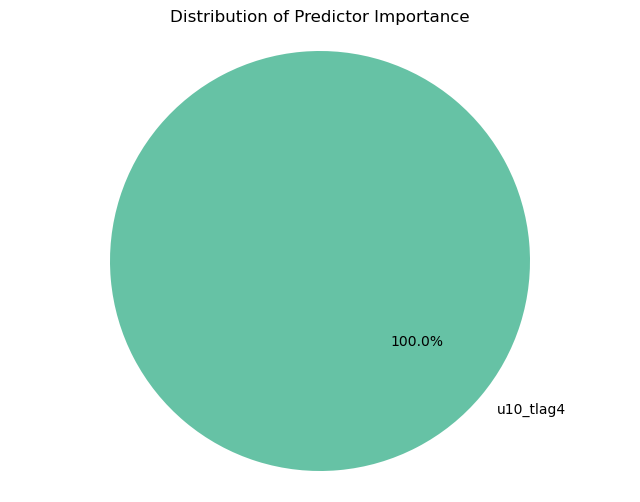

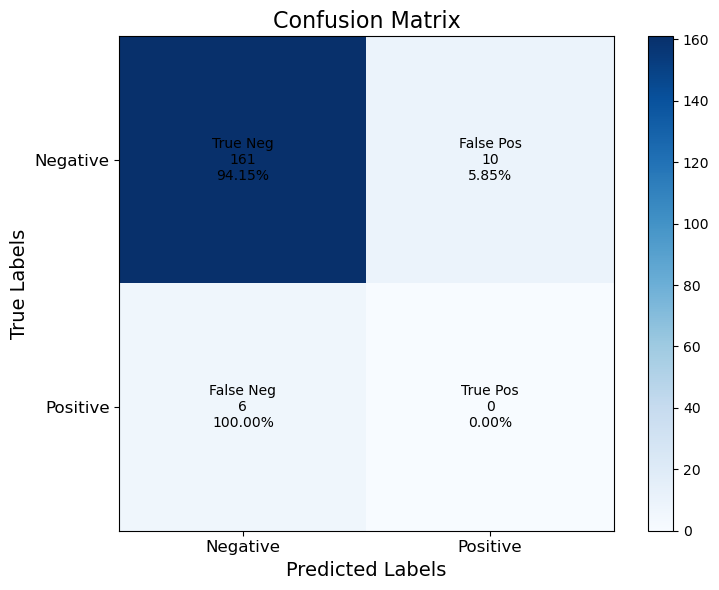

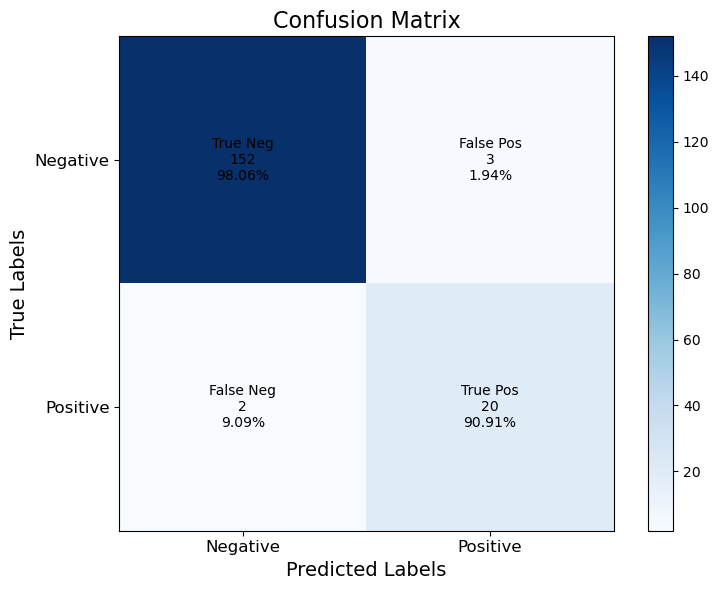

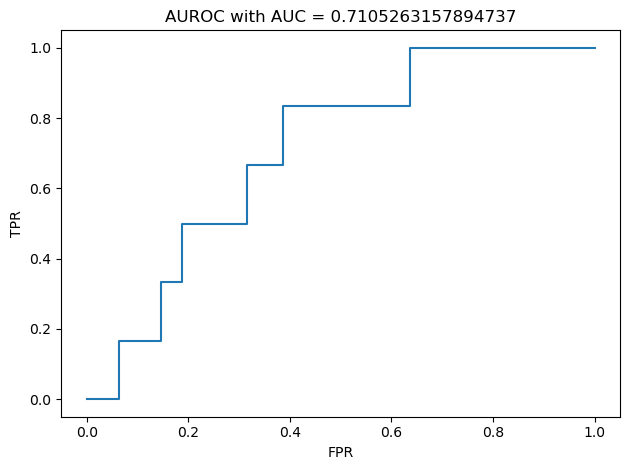

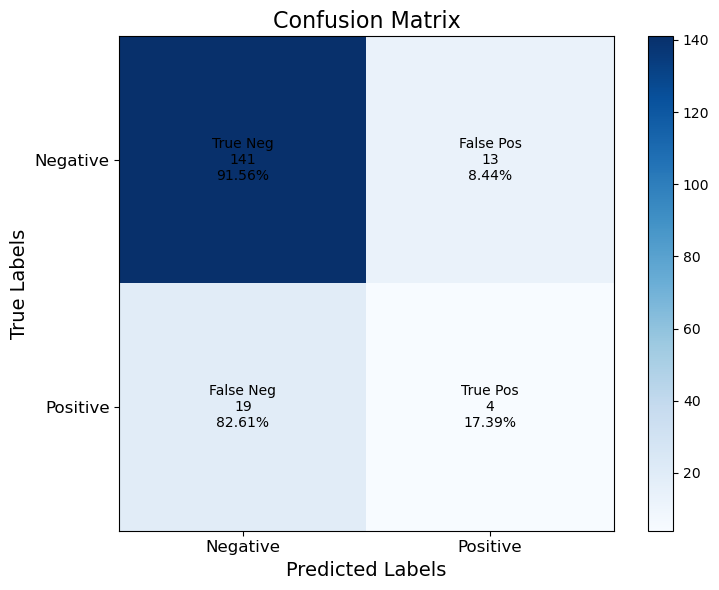

In [37]:
# Apply model fit for each station
for station in stations_of_model.keys():
    # Declaration
    station_name = station
    model_run_code = f"{model_run}_{stations_of_model[station]}" # For saving data
    n_pred_features = len(predictor_lats) * len(predictor_lons) # Number of features per predictor
    main_folder = f"results/random_forest/{model_run_code}/" # Saving results here
    saver.directory_existance(main_folder)
    
    # Select one station for train, test and validation data
    Y_train = predictand_train["exceedance"].sel(station=station).dropna("date_time")
    Y_test = predictand_test["exceedance"].sel(station=station).dropna("date_time")
    Y_valid = predictand_valid["exceedance"].sel(station=station).dropna("date_time")

    # Looping over all predictor combinations and timelags within experiment setup
    for run_id, selected_predictors in enumerate(predictors_of_model):
        # Write console output to a file
        file_path = f'{main_folder}output_runid{run_id}.txt'
        tee = Tee(file_path)
        sys.stdout = tee

        # Console Info
        print(f"Run_ID: {run_id}, Model for Station: {station}, Predictors: {selected_predictors}")
        print(f"Number of Features per Predictor: {n_pred_features}")
        
        # Saving Predictor Names
        fname = f"predictors_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{main_folder}{fname}", selected_predictors)
        print(f"Saved {main_folder}{fname}")

        # Whether pf is the only predictor:
        # Some functions will be skipped then
        n_pfs = np.sum(
            np.char.count(
                np.array(selected_predictors), 
                "pf",
            )
        )
        is_pf_only = (n_pfs == len(selected_predictors)) # Bool
        
        # Select timelags of current experiment
        timelags = timelags_of_model[run_id]
        
        # Convert Training, test and valid data into needed format of model fit 

        ## Train
        X_train, y_train, pred_units, pred_names, n_pfs = prep(
            era5_daily = era5_predictor_train, 
            prefilling_predictor = pf_predictor_train,
            gesla_predictand = Y_train, 
            predictors = selected_predictors, 
            timelags = timelags,
        )

        ## Test
        X_test, y_test, pred_units, pred_names, n_pfs = prep(
            era5_daily = era5_predictor_test, 
            prefilling_predictor = pf_predictor_test,
            gesla_predictand = Y_test, 
            predictors = selected_predictors, 
            timelags = timelags,
        )
        
        ## Validation
        X_valid, y_valid, pred_units, pred_names, n_pfs = prep(
            era5_daily = era5_predictor_valid, 
            prefilling_predictor = pf_predictor_valid,
            gesla_predictand = Y_valid, 
            predictors = selected_predictors, 
            timelags = timelags,
        )
                     
        # Fit a model to the training data
        model, hparam_grid_opt, X_train, X_test, y_train, y_test, X_test_unscaled, s = model_training(
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test,
        clf=clf,
        random_state=random_state,
        is_scaled=is_scaled,
        optimizer=optimizer,
        hparam_grid=hparam_grid,
        k=k,
        n_iter=n_iter,
        n_jobs=-1,
            )

        ## Saving the model
        subfolder = "model/"
        saver.directory_existance(f"{main_folder}{subfolder}")
        filename = f'{optimizer}_{run_id}.sav'
        pickle.dump(model, open(f'{main_folder}{subfolder}{filename}', 'wb'))
        print(f"model saved to {main_folder}{subfolder}{filename}")

        ## Save Scaler
        filename = f'{optimizer}_{run_id}_scaler.pkl'
        with open(f"{main_folder}{subfolder}{filename}",'wb') as f:
            pickle.dump(s, f)
        print(f"scaler saved to {main_folder}{subfolder}{filename}")

        ## Save hyperparameters
        hp_folder = f"{main_folder}{subfolder}"
        saver.directory_existance(hp_folder)
        saver.save_hpdict(hparam_grid_opt, run_id, model_run_code, percentile, hp_folder)
        print("Saved Hyperparameters")

        # Scale the validation data (train and test is scaled during model fit)
        X_valid_unscaled = X_valid
        if is_scaled:
            X_valid = s.transform(X_valid)
            
        # Evaluation of the model on the test set

        ## Plot predictor maps and importance areas
        if not is_pf_only:
            visualisation.mean_pms(
            model = model,
            y_test = y_test,
            X_test = X_test,
            X_test_unscaled = X_test_unscaled,
            predictors = selected_predictors,
            timelags = timelags,
            pred_units = pred_units,
            lons = predictor_lons,
            lats = predictor_lats,
            cmap = cmap, 
            colorbar_range = colorbar_range,
            nlevels = nlevels,
            station_name = station_name,
            station_positions = station_positions,
            model_run_code = model_run_code,
            run_id = run_id,
            )
            
        ## Compute Importance per Predictor and Visualize it
        pie_fig, importance_dict = visualisation.visualize_importance(
            model, 
            n_pred_features, 
            selected_predictors, 
            timelags)

        ### Save Pie-Chart of importance and values
        fname = f"{main_folder}importance_pie_{str(percentile)[-2:]}_{run_id}.pdf"
        pie_fig.savefig(fname)
        print(f"saved Pie-Chart to : {main_folder}{fname}")
        fname = f"importance_{str(percentile)[-2:]}_{run_id}"
        with open(f"{main_folder}{fname}", 'wb') as f:
            pickle.dump(importance_dict, f)
        print(f"saved Importance-Values to : {main_folder}{fname}")
        
        ## Evaluate Model Scores
        test_score = model.score(X_test, y_test)
        train_score = model.score(X_train, y_train)
        relative_score = evaluation.relative_scores(train_score, test_score)

        ### Save Scores
        fname = f"testscore_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{main_folder}{fname}", test_score)
        print(f"saved testscore to : {main_folder}{fname}")
        fname = f"trainscore_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{main_folder}{fname}", train_score)
        print(f"saved trainscore to : {main_folder}{fname}")
        fname = f"relativescore_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{main_folder}{fname}", relative_score)
        print(f"saved relativescore to : {main_folder}{fname}")
        
        ## Confusion Matrix Metrics
        cfm_fig1 = visualisation.plot_cfm(model, X_test, y_test)
        cfm_fig2 = visualisation.plot_cfm(model, X_train, y_train) 
        metrics1 = evaluation.cfm_metrics(model, X_test, y_test)
        metrics2 = evaluation.cfm_metrics(model, X_train, y_train)

        ### Save CFM and its Metrics
        fname = f"{main_folder}testcf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
        cfm_fig1.savefig(fname)
        print(f"saved cf matrix to : {fname}")
        fname = f"{main_folder}traincf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
        cfm_fig2.savefig(fname)
        print(f"saved cf matrix to : {fname}")
        fname = f"testcf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
        with open(f"{main_folder}{fname}", 'wb') as f:
            pickle.dump(metrics1, f)
        fname = f"traincf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
        with open(f"{main_folder}{fname}", 'wb') as f:
            pickle.dump(metrics2, f)

        print(f"saved cf metrics to : {fname}")
        
        ## Compute AUROC
        y_test_proba = model.predict_proba(X_test)[:, 1] # Prob. for predicting 0 or 1, we only need second c
        fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
        auc = roc_auc_score(y_test, y_test_proba)
        
        ### Plot AUROC
        auroc_fig, ax = plt.subplots(tight_layout=True)
        ax.plot(fpr, tpr)
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title(f"AUROC with AUC = {auc}")
        
        ### Save AUROC
        fname = f"{main_folder}AUROC_{str(percentile)[-2:]}_{run_id}.pdf"
        auroc_fig.savefig(fname)
        print(f"saved AUROC to : {fname}")

        ###----------------------------------------------------------------------
        ### VALIDATION
        ###----------------------------------------------------------------------
        save_id = "unknown"

        # Evaluation

        ## Visualize predictor maps and importance area on unkown data
        if not is_pf_only:
            visualisation.mean_pms(
            model = model,
            y_test = y_valid,
            X_test = X_valid,
            X_test_unscaled = X_valid_unscaled,
            predictors = selected_predictors,
            timelags = timelags,
            pred_units = pred_units,
            lons = predictor_lons,
            lats = predictor_lats,
            cmap = cmap, 
            colorbar_range = colorbar_range,
            nlevels = nlevels,
            station_name = station_name,
            station_positions = station_positions,
            model_run_code = model_run_code,
            run_id = run_id,
            save_id = save_id,
            )
    
        ## Evaluate Model Scores
        test_score = model.score(X_valid, y_valid)
        fname = f"validationscore_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{main_folder}{fname}", test_score)
        print(f"saved validationscore_ to : {main_folder}{fname}")
        
        ## Confusion Matrix Metrics
        cfm_fig1 = visualisation.plot_cfm(model, X_valid, y_valid)
        metrics1 = evaluation.cfm_metrics(model, X_valid, y_valid)
        
        ### Save CFM and its Metrics
        fname = f"{main_folder}validation-cf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
        cfm_fig1.savefig(fname)
        print(f"saved cf matrix to : {fname}")
        fname = f"validation-cf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
        with open(f"{main_folder}{fname}", 'wb') as f:
            pickle.dump(metrics1, f)
        fname = f"validation-cf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"

        sys.stdout = tee.stdout
        tee.close()

In [36]:
reload(visualisation)

<module 'data.visualisation' from 'c:\\Users\\belli\\OneDrive\\Alle_Ordner\\Coding\\Python\\RFSLR\\data\\visualisation.py'>